In [ ]:
!pip install pandas
!pip install numpy
!pip install matplotlib

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [ ]:
# 1. 데이터 로드 및 전처리
file_path = "BTCUSDT20250115.csv"
btc_data = pd.read_csv(file_path)

# 타임스탬프 변환 및 인덱스 설정
btc_data['Timestamp'] = pd.to_datetime(btc_data['Timestamp'])
btc_data.set_index('Timestamp', inplace=True)

# 필요한 열만 선택
btc_data = btc_data[['Close', 'Volume']]

# 5분 단위로 다운샘플링
btc_data = btc_data.resample('5T').agg({'Close': 'last', 'Volume': 'sum'}).dropna()

# 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(btc_data)
# 데이터를 0~1 로 나누는 이유는 모델이 학습할 때 더욱 안정적임

<ipython-input-7-5b2ca33d685e>:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  btc_data = btc_data.resample('5T').agg({'Close': 'last', 'Volume': 'sum'}).dropna()


In [ ]:
# 2. 시계열 데이터 분할 함수
def create_dataset(dataset, look_back=60):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, :])  # 과거 look_back 분의 데이터
        y.append(dataset[i + look_back, 0])   # 현재 Close 값
    return np.array(X), np.array(y)

look_back = 60
X, y = create_dataset(scaled_data, look_back)

In [ ]:
# 3. 데이터 분리
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [ ]:
# 4. LSTM 모델 설계
model = Sequential()
# units는 기억셀(cell) units가 커질 수록 복잡한 패턴학습이 쉬어지지만 계산 비용 증가
# return_sequences 첫 번쨰 Layer
# True면 각 시점(time step)의 출력을 다음 레이어로 전달
# False면 마지막 시점의 출력만 다음 레이어로 전달
# input_shape[1]은 과거 look_back 타임 스텝 , input_shape[2]는 특성수
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Close 값 예측
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# 5. 모델 학습
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 285s 55ms/step - loss: 0.0022 - val_loss: 1.5673e-04
Epoch 2/50
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 269s 53ms/step - loss: 4.8477e-04 - val_loss: 1.0630e-05
Epoch 3/50
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 320s 53ms/step - loss: 4.5195e-04 - val_loss: 1.0271e-04
Epoch 4/50
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 268s 53ms/step - loss: 4.4991e-04 - val_loss: 7.8927e-06
Epoch 5/50
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 325s 53ms/step - loss: 4.3933e-04 - val_loss: 8.5205e-05
Epoch 6/50
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 273s 54ms/step - loss: 4.2838e-04 - val_loss: 2.2206e-05
Epoch 7/50
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 316s 53ms/step - loss: 4.2979e-04 - val_loss: 6.9679e-06
Epoch 8/50
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 268s 53ms/step - loss: 4.2306e-04 - val_loss: 3.1624e-05
Epoch 9/50
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 268s 53ms/step - loss: 4.2585e-04 - val_loss: 6.9013e-05
Epoch 10/50
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 324s 53ms/step - loss: 4.2807e-04 - val_loss: 6.8062e-06
Epoch 11/50
5

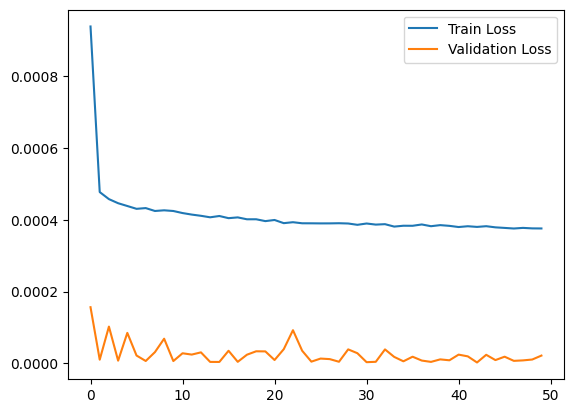

In [ ]:
# 6. 결과 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

1271/1271 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step


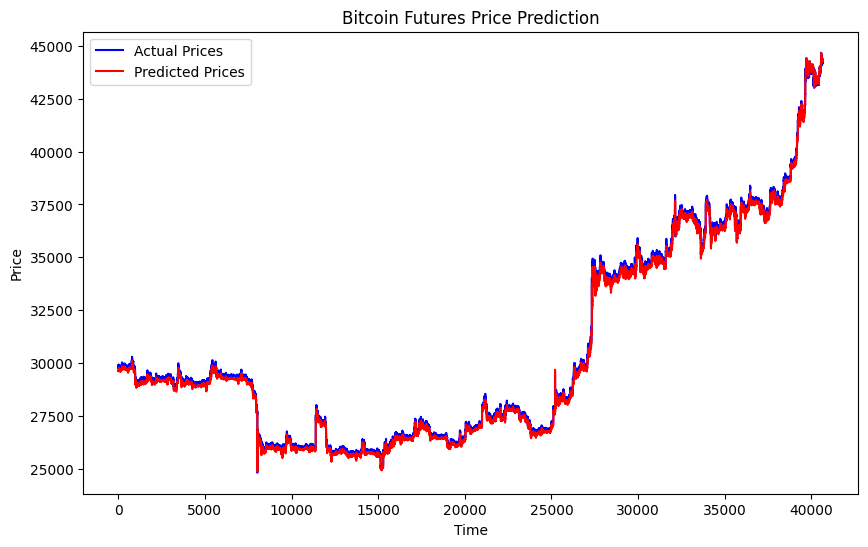

In [ ]:
# 7. 예측 및 평가
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(np.concatenate([predicted_prices, np.zeros((len(predicted_prices), 1))], axis=1))[:, 0]
actual_prices = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((len(y_test), 1))], axis=1))[:, 0]

plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='blue', label='Actual Prices')
plt.plot(predicted_prices, color='red', label='Predicted Prices')
plt.title('Bitcoin Futures Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()